# Predictive Data Mining
IFN645 - Data Mining Technologies and Applications
Due date: 7th April, 2019

Before answering any questions we need to import the neccessary libraries and data:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score
df = pd.read_csv('./data.csv')

# Toggle whether or not to show output.
verbose = True
quick_mode = True
target_value = "IsBadBuy"

C:\Users\Schmidt\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (27) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Task 1 - Data Selection and Distribution. 
#### 1.1 What is the proportion of cars who can be classified as a “kick”?
The proportion of *kicks* can be calculated using the function .mean() because the data is stored binary in the column *IsBadBuy*.  12.95% of the cars are *kicks* in the provided dataset.

In [2]:
if(verbose):
    print("Percentage of kicks: " + str(df[target_value].mean() * 100) + "%")

Percentage of kicks: 12.94965763333012%


#### 1.2 Did you have to fix any data quality problems? Detail them.
We found a bunch of data quality problems that we had to take care of.

Almost all data was missing on 44 of the rows, so we decided to remove them from the dataset. The percentage of *kicks* remained 12.95%.

In [3]:
c_name = "VehYear"
df[c_name] = df[c_name].fillna(0).astype(int)
if(verbose):
    print(df.loc[df[c_name] == 0])
df = df[df[c_name] != 0]

       PurchaseID  PurchaseTimestamp      PurchaseDate Auction  VehYear Make  \
20512       20512         1279065600  14/07/2010 10:00     NaN        0  NaN   
20513       20513         1279065600  14/07/2010 10:00     NaN        0  NaN   
20514       20514         1279065600  14/07/2010 10:00     NaN        0  NaN   
20515       20515         1279065600  14/07/2010 10:00     NaN        0  NaN   
20516       20516         1279065600  14/07/2010 10:00     NaN        0  NaN   
20676       20676         1286496000   8/10/2010 10:00     NaN        0  NaN   
20677       20677         1286496000   8/10/2010 10:00     NaN        0  NaN   
20678       20678         1286928000  13/10/2010 10:00     NaN        0  NaN   
20679       20679         1286928000  13/10/2010 10:00     NaN        0  NaN   
20680       20680         1286928000  13/10/2010 10:00     NaN        0  NaN   
20681       20681         1286928000  13/10/2010 10:00     NaN        0  NaN   
20682       20682         1286928000  13

Some columns required data cleaning. As we did not have a data/domain expert available we had to make some assumptions:
- *Manual* and *MANUAL* is assumed to be the same in the column *Transmission*.
- All values except 0 and 0.0 is assumed to be 1 in the column *IsOnlineSale*.
- *IsOnlineSale* should be represented as a binary value.
- *IsBadBuy* should be represented as binary value.
- All *MMR...* values should be interpreted as numbers, not strings.
- *WheelType* empty cells should be *?*.

['AUTO' 'MANUAL' 'Manual' '?']
['AUTO' 'MANUAL' '?']


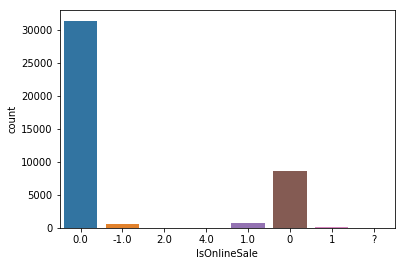

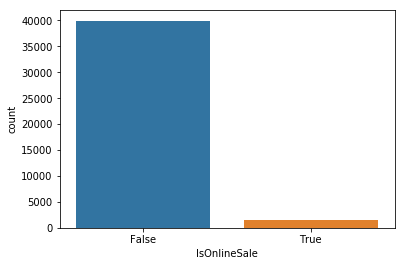

In [4]:
c_name = "Transmission"
if(verbose):
    print(df[c_name].unique())
df[c_name] = df[c_name].mask(df[c_name] == "Manual", "MANUAL")
if(verbose):
    print(df[c_name].unique())
    
c_name = "IsOnlineSale"
if(verbose):
    dg = sns.countplot(data=df, x=c_name)
    plt.show()

df[c_name] = df[c_name].mask(df[c_name] == 0.0, "0")
df[c_name] = np.where(df[c_name] == "0", False, True)

if(verbose):
    dg = sns.countplot(data=df, x=c_name)
    plt.show()
    
c_name = "IsBadBuy"
if(verbose):
    df[c_name].unique()
df[c_name] = df[c_name].astype(bool)
if(verbose):
    df[c_name].unique()
    
     
for c_name in ["MMRAcquisitionAuctionAveragePrice",
              "MMRAcquisitionAuctionCleanPrice",
              "MMRAcquisitionRetailAveragePrice",
              "MMRAcquisitonRetailCleanPrice",
              "MMRCurrentAuctionAveragePrice",
              "MMRCurrentAuctionCleanPrice",
              "MMRCurrentRetailAveragePrice",
              "MMRCurrentRetailCleanPrice",
              "MMRCurrentRetailRatio",
              "VehBCost"]:
    df[c_name] = df[c_name].mask(df[c_name] == "?", 0)
    df[c_name] = df[c_name].mask(df[c_name] == "#VALUE!", 0)
    df[c_name] = pd.to_numeric(df[c_name])
    df[c_name] = df[c_name].mask(df[c_name] == 1, 0)
    
c_name = "WheelType"
df[c_name] = df[c_name].fillna("?")

#### 1.3 Can you identify any clear patterns by initial exploration of the data using histogram or box plot?
The *VehYear* column, the year in which the car was made - does seems to have a influence on the *IsBadBuy* varible.  
It is more likely that an older car is a *kick*.

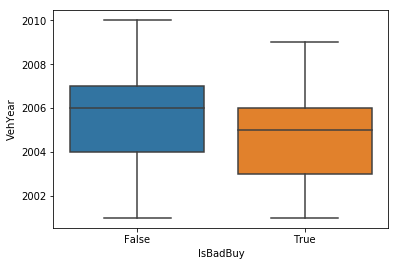

In [5]:
if(verbose):
    ax = sns.boxplot(x=target_value, y='VehYear', data=df)
    plt.show()

#### 1.4 What variables did you include in the analysis and what were their roles and measurement level set? Justify your choice.
We decided to drop the following columns:
- PurchaseID
- PurchaseTimestamp
- PurchasseData
- WheelTypeID
- PRIMEUNIT
- AUCGUART
- ForSale

Identification columns is not interesting. Almost all cars are marked as for sale. *PRIMEUNIT* and *AUCGUART* is missing data in most of the data entries.

In [6]:
df.drop(['PurchaseID','PurchaseTimestamp','PurchaseDate','WheelTypeID','PRIMEUNIT','AUCGUART','ForSale'],axis=1,inplace=True)

#### 1.5 What distribution scheme did you use? What data partitioning allocation did you set? Explain your selection.
The distribution between good and bad buys was very skewed, which made our prediction models have a heavy tendency to predict most cars as being good buys. We decided to use undersampling to counter the skewness - so the distribution between good and bay buys were equal in our traning sets.

## Task 2 - Predictive Modeling Using Decision Trees

In [7]:
# prepare data for decision tree
df_decision = pd.get_dummies(df)
df_decision = df_decision.dropna()

# target/input split
y = df_decision[target_value]
X = df_decision.drop([target_value],axis = 1)

# setting random state
rs = 10

# undersampling 
badBuy_indices = df_decision[df_decision[target_value] == 0].index

sample_size = sum(df_decision.IsBadBuy == 1)

random_indices = np.random.choice(badBuy_indices, sample_size, replace=False)

Non_badBuy_sample = df_decision.loc[random_indices]

Badbuys = df_decision.loc[df_decision[target_value]==1]

sample_data = Badbuys.append(Non_badBuy_sample,ignore_index=True)
X = sample_data.drop([target_value],axis = 1)
y = sample_data[target_value]

X_mat = X.as_matrix()
X_train, X_test, y_train, y_test = train_test_split(X_mat, y, test_size=0.3, stratify=y, random_state=rs)

C:\Users\Schmidt\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


#### 2.1 Build a decision tree using the default setting. 
*(a) What is the classification accuracy on training and test datasets?*  
Full print-out provided below. 77% on training, 66% on test.

*(b) What is the size of tree (i.e. number of nodes)?*  
Default settings gives a tree with 2743 nodes, tweaked has 53 nodes.

*(c) How many leaves are in the tree that is selected based on the validation dataset?*  
27 leaves in the tree with a total of 53 nodes.

*(d) Which variable is used for the first split? What are the competing splits for this first split?*  
Our tree first splits on *WheelType_?*, or in English words - weather the type of wheels on the car is known.
Another close contender is *VehYear*, the year the vechicle was manufactured.

*(e) What are the 5 important variables in building the tree?*  
- WheelType (unknown, boolean value)
- VehYear
- MMRAcquisitionAuctionAveragePrice
- VehBCost
- VehOdo

*(f) Report if you see any evidence of model overfitting.*  
There is signs of overfitting for the default settings and on the tweaked tree.

*(g) Did changing the default setting (i.e., only focus on changing the setting of the number of splits to create a node) help improving the model? Answer the above questions on the best performing tree.*  
Changing **min_samples_leaf** had a negative effect on the results.  
Changing **max_depth** helped us get better result on the test data (minimized overfitting).

In [13]:
model = DecisionTreeClassifier(random_state=rs)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
if(verbose):
    print("DEFAULT SETTINGS:")
    print(classification_report(y_test, y_pred))
    print("Number of nodes: " + str(model.tree_.node_count))

model = DecisionTreeClassifier(max_depth=5,random_state=rs)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
if(verbose):
    print("\nTWEAKED SETTINGS:")
    print(classification_report(y_test, y_pred))
    print("Number of nodes: " + str(model.tree_.node_count))

DEFAULT SETTINGS:
Train accuracy: 0.7105511386605579
Test accuracy: 0.6611128575919523
              precision    recall  f1-score   support

       False       0.63      0.62      0.62      1590
        True       0.62      0.64      0.63      1591

   micro avg       0.63      0.63      0.63      3181
   macro avg       0.63      0.63      0.63      3181
weighted avg       0.63      0.63      0.63      3181

Number of nodes: 2743

TWEAKED SETTINGS:
Train accuracy: 0.7105511386605579
Test accuracy: 0.6611128575919523
              precision    recall  f1-score   support

       False       0.62      0.75      0.68      1590
        True       0.69      0.54      0.60      1591

   micro avg       0.65      0.65      0.65      3181
   macro avg       0.65      0.65      0.64      3181
weighted avg       0.65      0.65      0.64      3181

Number of nodes: 53
WheelType_? : 0.5675780202738993
VehYear : 0.19385020918678159
MMRAcquisitionAuctionAveragePrice : 0.06819617350626507
VehBCost :

#### 2.2 Build another decision tree tuned with GridSearchCV

In [14]:
if(quick_mode):
    print("Turn off quick mode to enable gridsearch.")
else:
    params = {'criterion': ['gini', 'entropy'],
          'max_depth': range(2, 10),
          'min_samples_leaf': range(20, 60, 10)}

    cv = GridSearchCV(param_grid=params, estimator=DecisionTreeClassifier(random_state=rs), cv=10)
    cv.fit(X_train, y_train)
    
    if(verbose):
        print("Train accuracy:", cv.score(X_train, y_train))
        print("Test accuracy:", cv.score(X_test, y_test))

    y_pred = cv.predict(X_test)
    if(verbose):
        print(classification_report(y_test, y_pred))

Train accuracy: 0.7105511386605579
Test accuracy: 0.6611128575919523
              precision    recall  f1-score   support

       False       0.63      0.77      0.69      1590
        True       0.70      0.55      0.62      1591

   micro avg       0.66      0.66      0.66      3181
   macro avg       0.67      0.66      0.66      3181
weighted avg       0.67      0.66      0.66      3181



*(a) What is the classification accuracy on training and test datasets?*  
The result is 71% on the training data and 66% on the test data. The full report is printed above.  

*(b) What is the size of tree (i.e. number of nodes)? Is the size different from the maximal tree or the tree in the previous step? Why?*  
It is way lower than the maximal tree - a maximal tree would not be very useful, it would be overfitting a lot. Also, our max_depth does not allow for the creation of a maximal tree. The previous tree contained 53 nodes and the tuned tree also contains 53 nodes.

*(c) How many leaves are in the tree that is selected based on the validation data set?*  
This tree contains 27 leaves.

*(d) Which variable is used for the first split? What are the competing splits for this first split?*  
Same as previous tree, the type of the wheel.

*(e) What are the 5 important variables in building the tree?*
- WheelType (unknown, boolean value)
- VehYear
- MMRAcquisitionAuctionAveragePrice
- VehBCost
- VehOdo

*(f) Report if you see any evidence of model overfitting.*   
There is a slight overfitting.

*(g) What are the parameters used? Explain your choices.*  
We tried to test both the *gini* and *entropy* way of measuring quality of the split.  
*Max_depth* is varied to try to improve accuracy without overfitting the model and the *min_samples_leaf* to test if internal node splitting would result in a different and more accurate tree.

#### 2.3 What is the significant difference do you see between these two decision tree models?
*How do they compare performance-wise? Explain why those changes may have happened.*  
The performance change is insignificant. The two decision trees are almost the same.  
This is probably caused by the most important configuration in this case being *max_depth* which we adjusted before running grid search to find parameters.

#### 2.4 From the better model, can you identify which cars could potential be *kicks*?
Cars where the wheel type is known and from the MANHEIM auction are likely to be good buys. 
Cars where the wheel type is unknown, 

## Task 3 - Predictive Modeling Using Regression

In [12]:
sample_data.info()


X = sample_data.drop([target_value],axis = 1)
y = sample_data[target_value]

X_mat = X.as_matrix()
X_train, X_test, y_train, y_test = train_test_split(X_mat, y, test_size=0.3, stratify=y, random_state=rs)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10602 entries, 0 to 10601
Columns: 127 entries, VehYear to VNST_WV
dtypes: bool(2), float64(11), int32(1), int64(1), uint8(112)
memory usage: 2.2 MB


C:\Users\Computer\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  import sys


#### 3.1 In preparation for regression, is any imputation of missing values needed for this data set? List the variables that did.
> 509 cars need *MMR___* data  
> 44 cars have already been removed due to missing information (year)

In [13]:
if(verbose):
    print("\nThe following columns still have missing values:")
nan_list = list()
for c_name in list(sample_data):
    if(sample_data[c_name].isnull().values.any()):
        nan_list.append(c_name)
        if(verbose):
            print(c_name)

sample_data = sample_data.dropna(subset=nan_list) 


The following columns still have missing values:


#### 3.2 Apply transformation method(s) to the variable(s) that need it. List the variables that needed it

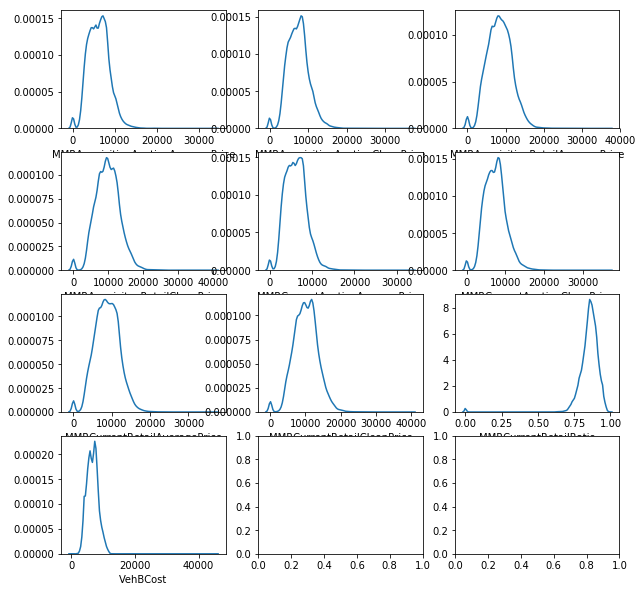

In [14]:
def plot_skewed_columns(df):
    # setting up subplots for easier visualisation
    f, axes = plt.subplots(4,3, figsize=(10,10), sharex=False)

    sns.distplot(df['MMRAcquisitionAuctionAveragePrice'].dropna(), hist=False, ax=axes[0,0])
    sns.distplot(df['MMRAcquisitionAuctionCleanPrice'].dropna(), hist=False, ax=axes[0,1])
    sns.distplot(df['MMRAcquisitionRetailAveragePrice'].dropna(), hist=False, ax=axes[0,2])
    sns.distplot(df['MMRAcquisitonRetailCleanPrice'].dropna(), hist=False, ax=axes[1,0])
    sns.distplot(df['MMRCurrentAuctionAveragePrice'].dropna(), hist=False, ax=axes[1,1])
    sns.distplot(df['MMRCurrentAuctionCleanPrice'].dropna(), hist=False, ax=axes[1,2])
    sns.distplot(df['MMRCurrentRetailAveragePrice'].dropna(), hist=False, ax=axes[2,0])
    sns.distplot(df['MMRCurrentRetailCleanPrice'].dropna(), hist=False, ax=axes[2,1])
    sns.distplot(df['MMRCurrentRetailRatio'].dropna(), hist=False, ax=axes[2,2])
    sns.distplot(df['VehBCost'].dropna(), hist=False, ax=axes[3,0])

    plt.show()
    
plot_skewed_columns(df)

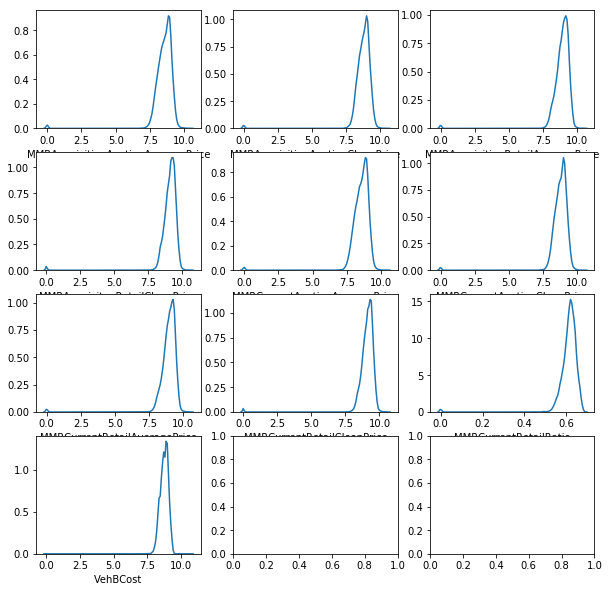

In [15]:
# list columns to be transformed
columns_to_transform = ['MMRAcquisitionAuctionAveragePrice', 'MMRAcquisitionAuctionCleanPrice', 'MMRAcquisitionRetailAveragePrice',
                        'MMRAcquisitonRetailCleanPrice','MMRCurrentAuctionAveragePrice', 'MMRCurrentAuctionCleanPrice',
                        'MMRCurrentRetailAveragePrice', 'MMRCurrentRetailCleanPrice','MMRCurrentRetailRatio','VehBCost']

# copy the dataframe
df_log = sample_data.copy()

# transform the columns with np.log
for col in columns_to_transform:
    df_log[col] = df_log[col].apply(lambda x: x+1)
    df_log[col] = df_log[col].apply(np.log)

# plot them again to show the distribution
plot_skewed_columns(df_log)

In [16]:
y_log = df_log[target_value]
X_log = df_log.drop([target_value], axis=1)

X_mat_log = X_log.as_matrix()
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(X_mat_log, y_log, test_size=0.3, stratify=y_log, 
                                                                    random_state=rs)

# standardise them
scaler_log = StandardScaler()
X_train_log = scaler_log.fit_transform(X_train_log, y_train_log)
X_test_log = scaler_log.transform(X_test_log)

C:\Users\Computer\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.
C:\Users\Computer\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Computer\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Computer\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


#### 3.3 Build a regression model using the default regression method with all inputs.

In [17]:
# fit it to training data
model = LogisticRegression(random_state=rs)
model.fit(X_train_log, y_train_log)

# classification report on test data
print("Train accuracy:", model.score(X_train_log, y_train_log))
print("Test accuracy:", model.score(X_test_log, y_test_log))


y_pred = model.predict(X_test_log)
if(verbose):
    print(classification_report(y_test_log, y_pred))

C:\Users\Computer\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Train accuracy: 0.6996361676323946
Test accuracy: 0.6828041496384785
              precision    recall  f1-score   support

       False       0.66      0.77      0.71      1590
        True       0.72      0.60      0.65      1591

   micro avg       0.68      0.68      0.68      3181
   macro avg       0.69      0.68      0.68      3181
weighted avg       0.69      0.68      0.68      3181



#### 3.3 ... Once you done it, build another one and tune it using GridSearchCV

In [18]:
# grid search CV
params = {'C': [pow(10, x) for x in range(-6, 4)]}

cv = GridSearchCV(param_grid=params, estimator=LogisticRegression(random_state=rs), cv=10, n_jobs=-1)
cv.fit(X_train_log, y_train_log)

# test the best model
print("Train accuracy:", cv.score(X_train_log, y_train_log))
print("Test accuracy:", cv.score(X_test_log, y_test_log))

y_pred = cv.predict(X_test_log)
print(classification_report(y_test_log, y_pred))

print(cv.best_params_)

C:\Users\Computer\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Train accuracy: 0.6996361676323946
Test accuracy: 0.6828041496384785
              precision    recall  f1-score   support

       False       0.66      0.77      0.71      1590
        True       0.72      0.60      0.65      1591

   micro avg       0.68      0.68      0.68      3181
   macro avg       0.69      0.68      0.68      3181
weighted avg       0.69      0.68      0.68      3181

{'C': 1}


*(h) Name the regression function used.*  
Logistic regression was used to build the model.

*(i) How much was the difference in performance of two models build, default and optimal?*  
We can tell from the result above. The GridSearchCV did not make any change to the result, and the parameter C is 1.

*(j) Show the set parameters for the best model. What are the parameters used?
Explain your decision. What are the optimal parameters?*  
The set parameters is based on GridSearchCV which tries different parameters from a typical range of values and pick the optimal ones. In sklearn logistic regression, regularisation is implemented in the hyperparameter C, which denotes the inverse of regularisation strength. Smaller C means stronger regularisation. The C for our best model is 1.

*(k) Report which variables are included in the regression model.*  
As we only droped 'PurchaseID','PurchaseTimestamp','PurchaseDate','WheelTypeID','PRIMEUNIT','AUCGUART','ForSale', all remained variables are all prossessed in the regression model.


In [19]:
sample_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10602 entries, 0 to 10601
Columns: 127 entries, VehYear to VNST_WV
dtypes: bool(2), float64(11), int32(1), int64(1), uint8(112)
memory usage: 2.2 MB


In [20]:
# grab feature importances from the model and feature name from the original X
coef = model.coef_[0]
feature_names = X_log.columns

# sort them out in descending order
indices = np.argsort(np.absolute(coef))
indices = np.flip(indices, axis=0)

# limit to 5 features, you can leave this out to print out everything
indices = indices[:5]

for i in indices:
    print(feature_names[i], ':', coef[i])

MMRAcquisitionAuctionAveragePrice : -1.193314843612966
MMRAcquisitionRetailAveragePrice : 1.0717034531878873
WheelType_? : 0.9931232544945365
MMRCurrentAuctionAveragePrice : 0.6003049590242948
MMRCurrentRetailCleanPrice : -0.5254876511841238


*(l) Report the top-5 important variables (in the order) in the model.*  
- MMRAcquisitionAuctionAveragePrice 
- MMRAcquisitionRetailAveragePrice  
- WheelType_? (it means unknown or not)
- MMRCurrentAuctionAveragePrice   
- MMRCurrentRetailCleanPrice   

*(m) What is classification accuracy on training and test datasets?*  

In [21]:
print("Train accuracy:", model.score(X_train_log, y_train_log))
print("Test accuracy:", model.score(X_test_log, y_test_log))
print(classification_report(y_test_log, y_pred))

Train accuracy: 0.6996361676323946
Test accuracy: 0.6828041496384785
              precision    recall  f1-score   support

       False       0.66      0.77      0.71      1590
        True       0.72      0.60      0.65      1591

   micro avg       0.68      0.68      0.68      3181
   macro avg       0.69      0.68      0.68      3181
weighted avg       0.69      0.68      0.68      3181



*(n) Report any sign of overfitting*

We can see the test accuracy is lower than train accuracy due to a slight overfitting.

#### 3.4 Build another regression model using the subset of inputs selected by RFE and selection by model method. Answer the followings:

In [22]:
from sklearn.feature_selection import RFECV

rfe = RFECV(estimator = LogisticRegression(random_state=rs,solver = 'liblinear'), cv=10)
rfe.fit(X_train_log, y_train_log) # run the RFECV



X_train_sel = rfe.transform(X_train_log)
X_test_sel = rfe.transform(X_test_log)

params = {'C': [pow(10, x) for x in range(-6, 4)]}

cv = GridSearchCV(param_grid=params, estimator=LogisticRegression(random_state=rs), cv=10, n_jobs=-1)
cv.fit(X_train_sel, y_train_log)

# test the best model
print("Train accuracy:", cv.score(X_train_sel, y_train_log))
print("Test accuracy:", cv.score(X_test_sel, y_test_log))

y_pred = cv.predict(X_test_sel)
print(classification_report(y_test_log, y_pred))

# print parameters of the best model
print(cv.best_params_)

C:\Users\Computer\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Train accuracy: 0.6992319094461663
Test accuracy: 0.6831185161898774
              precision    recall  f1-score   support

       False       0.66      0.77      0.71      1590
        True       0.72      0.60      0.65      1591

   micro avg       0.68      0.68      0.68      3181
   macro avg       0.69      0.68      0.68      3181
weighted avg       0.69      0.68      0.68      3181

{'C': 1}


In [23]:
print(classification_report(y_test_log, y_pred))

              precision    recall  f1-score   support

       False       0.66      0.77      0.71      1590
        True       0.72      0.60      0.65      1591

   micro avg       0.68      0.68      0.68      3181
   macro avg       0.69      0.68      0.68      3181
weighted avg       0.69      0.68      0.68      3181



In [24]:
print("Original feature set", X_train_log.shape[1])
print("Number of features after elimination", rfe.n_features_)

Original feature set 126
Number of features after elimination 69


*(a) Report which variables are included in the regression model.* 
There are 69 variables are selected by RFE to process in the regression model.

*(b) Report the top-5 important variables (in the order) in the model.*  
WheelType_?
MMRAcquisitionAuctionAveragePrice
MMRCurrentAuctionAveragePrice
MMRAcquisitionRetailAveragePrice
MMRCurrentRetailCleanPrice
the top-5 impoortant variables remain the same as only non-improtant variables are affected by RFE.

*(c). What are the parameters used? Explain your choices. What are the optimal parameters? Which regression function is being used?*  
Parameter C is used, which denotes the inverse of regularisation strength. cv is given as 10. Other parameters are all default values. 

*(d). Report any sign of overfitting.*  
Train accuracy: 0.616763239455599 Test accuracy: 0.6101854762653254 the Train accuracy is very close to the Test accuracy, it indicates there is no obivious overfitting.

*(e). What is classification accuracy on training and test datasets?*  
Train accuracy: 0.6939765530251988
Test accuracy: 0.6928638792832442

*(f). Did it improve/worsen the performance? Explain why those changes may have happened.*  
The performance is almost the same. Test accuracy is from 0.6828041496384785 to 0.6831185161898774. It sometimes imporved a bit and sometimes worsen a bit if we rerun all cells. I think it is because the non-important variables do not make much contribution to the result, so it does not make much difference whether we elinimate them or not.

#### 3.5 Using the best regression model, which cars could potential be “kicks”? Can you provide some descriptive summary of those cars?

We can interpret the regression model from its importance list. If a car has unknown WheelType, or the AuctionAveragePrice is quite low,it has higher possibility to be a kick. MMRAcquisitionRetailAveragePrice and MMRCurrentAuctionAveragePrice have postive influence on cars' reliability.

## Task 4 - Predictive Modeling Using Neural Networks

In [25]:
# data prep

df = pd.read_csv('data.csv')

df.drop(['PurchaseID','PurchaseTimestamp',
        'PurchaseDate','PRIMEUNIT','AUCGUART','ForSale','Color',
        'WheelType','Nationality','TopThreeAmericanName','WarrantyCost'],axis=1,inplace=True)

c_name = "VehYear"
df[c_name] = df[c_name].fillna(0).astype(int)
df = df[df[c_name] != 0]
    
c_name = "Transmission"
df[c_name] = df[c_name].mask(df[c_name] == "Manual", "MANUAL")
df[c_name] = df[c_name].mask(df[c_name] == "?", "AUTO")
    
c_name = "WheelTypeID"
df[c_name] = df[c_name].mask(df[c_name] == "0", "?")
df[c_name] = df[c_name].fillna("?")

c_name = "VehBCost"
df[c_name] = df[c_name].mask(df[c_name] == "?", "0")
df[c_name] = pd.to_numeric(df[c_name])
df[c_name] = df[c_name].mask(df[c_name] < 0, 0)

c_name = "IsOnlineSale"
df[c_name] = np.where(df[c_name] == "0", False, True)
    
c_name = "IsBadBuy"
df[c_name] = df[c_name].astype(bool)
    
collection = ["MMRAcquisitionAuctionAveragePrice",
              "MMRAcquisitionAuctionCleanPrice",
              "MMRAcquisitionRetailAveragePrice",
              "MMRAcquisitonRetailCleanPrice",
              "MMRCurrentAuctionAveragePrice",
              "MMRCurrentAuctionCleanPrice",
              "MMRCurrentRetailAveragePrice",
              "MMRCurrentRetailCleanPrice","MMRCurrentRetailRatio"]

for c_name in collection:
    df[c_name] = df[c_name].mask(df[c_name] == "?", 0)
    df[c_name] = df[c_name].mask(df[c_name] == "#VALUE!", 0)
    df[c_name] = pd.to_numeric(df[c_name])
    df[c_name] = df[c_name].mask(df[c_name] == 1, 0)

C:\Users\Computer\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (27) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [26]:
df_reg = pd.get_dummies(df)
df_reg = df_reg.dropna()

# undersampling 
badBuy_indices = df_reg[df_reg[target_value] == 0].index

sample_size = sum(df_reg.IsBadBuy == 1)

random_indices = np.random.choice(badBuy_indices, sample_size, replace=False)

Non_badBuy_sample = df_reg.loc[random_indices]

Badbuys = df_reg.loc[df_reg[target_value]==1]

sample_data = Badbuys.append(Non_badBuy_sample,ignore_index=True)
X = sample_data.drop([target_value],axis = 1)
y = sample_data[target_value]

X_mat = X.as_matrix()
X_train, X_test, y_train, y_test = train_test_split(X_mat, y, test_size=0.3, stratify=y, random_state=rs)

# train test split
y = sample_data['IsBadBuy']
X = sample_data.drop(['IsBadBuy'], axis=1)

X_mat = X.as_matrix()
X_train, X_test, y_train, y_test = train_test_split(X_mat, y, test_size=0.3, stratify=y, random_state=rs)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train, y_train)
X_test = scaler.transform(X_test)

C:\Users\Computer\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Users\Computer\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Users\Computer\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Computer\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Computer\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [27]:
# default neural network model
from sklearn.neural_network import MLPClassifier

model = MLPClassifier(random_state=rs)
model.fit(X_train, y_train)

print("Train accuracy:", model.score(X_train, y_train))
print("Test accuracy:", model.score(X_test, y_test))

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

print(model)

Train accuracy: 0.896240398868077
Test accuracy: 0.6513674944985853
              precision    recall  f1-score   support

       False       0.65      0.67      0.66      1590
        True       0.66      0.64      0.65      1591

   micro avg       0.65      0.65      0.65      3181
   macro avg       0.65      0.65      0.65      3181
weighted avg       0.65      0.65      0.65      3181

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=10, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)


C:\Users\Computer\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


*a. What is the network architecture?*  
The hidden layer sizes is 100.

*b. How many iterations are needed to train this network?*  
More than 200 as it warned max iterations reached.

*c. Do you see any sign of over-fitting?*  
Yes, as the train accuracy is much higher than test accuracy.

*d. Did the training process converge and resulted in the best model?*  
No, the training process did not converge and it is not the best model.

*e. What is classification accuracy on training and test datasets?*  
Train accuracy: 0.9016305080177873 Test accuracy: 0.66174159069475

In [28]:
# See how many input features we have by printing out the train shape.
print(X_train.shape)

(7421, 96)


In [29]:
# With 96 features, we will start tuning with one hidden layer of 5 to 96 neurons, increment of 15. 
params = {'hidden_layer_sizes': [(x,) for x in range(5, 96, 15)]}

cv = GridSearchCV(param_grid=params, estimator=MLPClassifier(random_state=rs), cv=10, n_jobs=-1)
cv.fit(X_train, y_train)

print("Train accuracy:", cv.score(X_train, y_train))
print("Test accuracy:", cv.score(X_test, y_test))

y_pred = cv.predict(X_test)
print(classification_report(y_test, y_pred))

print(cv.best_params_)

Train accuracy: 0.7186363023851233
Test accuracy: 0.6686576548255265
              precision    recall  f1-score   support

       False       0.65      0.73      0.69      1590
        True       0.69      0.61      0.65      1591

   micro avg       0.67      0.67      0.67      3181
   macro avg       0.67      0.67      0.67      3181
weighted avg       0.67      0.67      0.67      3181

{'hidden_layer_sizes': (5,)}


C:\Users\Computer\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [30]:

# new parameters
params = {'hidden_layer_sizes': [(3,), (5,), (7,), (9,)]}

cv = GridSearchCV(param_grid=params, estimator=MLPClassifier(random_state=rs), cv=10, n_jobs=-1)
cv.fit(X_train, y_train)

print("Train accuracy:", cv.score(X_train, y_train))
print("Test accuracy:", cv.score(X_test, y_test))

y_pred = cv.predict(X_test)
print(classification_report(y_test, y_pred))

print(cv.best_params_)

Train accuracy: 0.7186363023851233
Test accuracy: 0.6686576548255265
              precision    recall  f1-score   support

       False       0.65      0.73      0.69      1590
        True       0.69      0.61      0.65      1591

   micro avg       0.67      0.67      0.67      3181
   macro avg       0.67      0.67      0.67      3181
weighted avg       0.67      0.67      0.67      3181

{'hidden_layer_sizes': (5,)}


C:\Users\Computer\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [31]:
params = {'hidden_layer_sizes': [(3,), (5,), (7,), (9,)], 'alpha': [0.01,0.001, 0.0001, 0.00001]}

cv = GridSearchCV(param_grid=params, estimator=MLPClassifier(random_state=rs), cv=10, n_jobs=-1)
cv.fit(X_train, y_train)

print("Train accuracy:", cv.score(X_train, y_train))
print("Test accuracy:", cv.score(X_test, y_test))

y_pred = cv.predict(X_test)
print(classification_report(y_test, y_pred))

print(cv.best_params_)

Train accuracy: 0.7238916588060909
Test accuracy: 0.6724300534423138
              precision    recall  f1-score   support

       False       0.65      0.74      0.69      1590
        True       0.70      0.61      0.65      1591

   micro avg       0.67      0.67      0.67      3181
   macro avg       0.68      0.67      0.67      3181
weighted avg       0.68      0.67      0.67      3181

{'alpha': 1e-05, 'hidden_layer_sizes': (5,)}


C:\Users\Computer\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)



a. What is the network architecture?
The hidden layer sizes is 5 on alpha 0.001.

b. How many iterations are needed to train this network?
The training process converged on default max iterations of 200, thus it is lower than 200.

c. Do you see any sign of over-fitting?
Yes, as the train accuracy is a little higher than test accuracy.

d. Did the training process converge and resulted in the best model?
Yes, the training process converge and it is the best model.

e. What is classification accuracy on training and test datasets?
Train accuracy: 0.7288775097695729 Test accuracy: 0.6730587865451116

#### 4.3 Would feature selection help here?

Build another Neural Network model with inputs selected from RFE with regression (use the best model generated in Task 3) and selection with decision tree (use the best model from Task 2).

In [32]:
# use the transformed data
params = {'hidden_layer_sizes': [(3,), (5,), (7,), (9,)], 'alpha': [0.01,0.001, 0.0001, 0.00001]}

cv = GridSearchCV(param_grid=params, estimator=MLPClassifier(random_state=rs), cv=10, n_jobs=-1)
cv.fit(X_train_log, y_train_log)

print("Train accuracy:", cv.score(X_train_log, y_train_log))
print("Test accuracy:", cv.score(X_test_log, y_test_log))

y_pred = cv.predict(X_test_log)
print(classification_report(y_test_log, y_pred))

print(cv.best_params_)

Train accuracy: 0.7089341059156448
Test accuracy: 0.6762024520591009
              precision    recall  f1-score   support

       False       0.65      0.78      0.71      1590
        True       0.72      0.57      0.64      1591

   micro avg       0.68      0.68      0.68      3181
   macro avg       0.68      0.68      0.67      3181
weighted avg       0.68      0.68      0.67      3181

{'alpha': 0.0001, 'hidden_layer_sizes': (3,)}


In [33]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression

rfe = RFECV(estimator = LogisticRegression(random_state=rs, solver = 'liblinear'), cv=10)
rfe.fit(X_train_log, y_train_log)

print(rfe.n_features_)

69


In [34]:
# transform log 
X_train_rfe = rfe.transform(X_train_log)
X_test_rfe = rfe.transform(X_test_log)

# step = int((X_train_rfe.shape[1] + 5)/5);
params = {'hidden_layer_sizes': [(3,), (5,), (7,), (9,)], 'alpha': [0.01,0.001, 0.0001, 0.00001]}

cv = GridSearchCV(param_grid=params, estimator=MLPClassifier(random_state=rs), cv=10, n_jobs=-1)
cv.fit(X_train_rfe, y_train_log)

print("Train accuracy:", cv.score(X_train_rfe, y_train_log))
print("Test accuracy:", cv.score(X_test_rfe, y_test_log))

y_pred = cv.predict(X_test_rfe)
print(classification_report(y_test_log, y_pred))

print(cv.best_params_)

Train accuracy: 0.7334591025468266
Test accuracy: 0.6718013203395159
              precision    recall  f1-score   support

       False       0.66      0.73      0.69      1590
        True       0.69      0.62      0.65      1591

   micro avg       0.67      0.67      0.67      3181
   macro avg       0.67      0.67      0.67      3181
weighted avg       0.67      0.67      0.67      3181

{'alpha': 0.01, 'hidden_layer_sizes': (9,)}


C:\Users\Computer\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [35]:
from sklearn.tree import DecisionTreeClassifier

params = {'criterion': ['gini', 'entropy'],
        'max_depth': range(2, 10),
        'min_samples_leaf': range(20, 60, 10)}

cv = GridSearchCV(param_grid=params, estimator=DecisionTreeClassifier(random_state=rs), cv=10)
cv.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=10,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'criterion': ['gini', 'entropy'], 'max_depth': range(2, 10), 'min_samples_leaf': range(20, 60, 10)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [36]:
from sklearn.feature_selection import SelectFromModel

selectmodel = SelectFromModel(cv.best_estimator_, prefit=True)
X_train_sel_model = selectmodel.transform(X_train)
X_test_sel_model = selectmodel.transform(X_test)

print(X_train_sel_model.shape)

(7421, 9)


In [37]:
params = {'hidden_layer_sizes': [(3,), (5,), (7,), (9,)], 'alpha': [0.01,0.001, 0.0001, 0.00001]}

cv = GridSearchCV(param_grid=params, estimator=MLPClassifier(random_state=rs), cv=10, n_jobs=-1)
cv.fit(X_train_sel_model, y_train)

print("Train accuracy:", cv.score(X_train_sel_model, y_train))
print("Test accuracy:", cv.score(X_test_sel_model, y_test))

y_pred = cv.predict(X_test_sel_model)
print(classification_report(y_test, y_pred))

print(cv.best_params_)

Train accuracy: 0.6911467457216008
Test accuracy: 0.6824897830870795
              precision    recall  f1-score   support

       False       0.65      0.78      0.71      1590
        True       0.73      0.58      0.65      1591

   micro avg       0.68      0.68      0.68      3181
   macro avg       0.69      0.68      0.68      3181
weighted avg       0.69      0.68      0.68      3181

{'alpha': 0.01, 'hidden_layer_sizes': (7,)}


C:\Users\Computer\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


a. Did feature selection help here? Any change in the network architecture? What inputs are being used as the network input?

b. What is classification accuracy on training and test datasets? Is there any improvement in the outcome?

c. How many iterations are now needed to train this network?

d. Do you see any sign of over-fitting?

e. Did the training process converge and resulted in the best model?